In [1]:
from src.config.config import get_chat_model
from src.config.prompt import prompt as mi_prompt

import os
import openai
from langchain.chains import LLMChain
from src.tools.rag import RAGLocal
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition
from pydantic import BaseModel
from langgraph.graph import END



from src.components.utils import create_tool_node_with_fallback, route_tools, handle_tool_error,_print_event
from src.components.assistant import Assistant
from src.components.estado import State
from src.tools.Herramienta_RAG import Herramienta_RAG 

from src.tools.rag import init_rag


In [2]:
import logging, sys
logging.basicConfig(
    level=logging.DEBUG,               # o INFO
    stream=sys.stdout,
    format="%(levelname)s | %(name)s | %(message)s",
)
logger = logging.getLogger(__name__)

In [3]:
init_rag("data")
model = get_chat_model() 

In [4]:


def initialize_agent():

    try:
        # Define the LLM for the agent
        llm = model #gpt-4.1-2025-04-14 / claude-3-5-sonnet-latest /gpt-4o-2024-08-06 /gpt-4.1-2025-04-14

        # Define the system prompt for the agent using a chat prompt template
        # Build the prompt template
        prompt = mi_prompt


        # Define the tools that the agent can use
        tools = [
            Herramienta_RAG
            ]

        # Bind the tools to the LLM via the prompt
        assistant_runnable = prompt | llm.bind_tools(tools )

        # Build the state graph for the agent
        #Initialize the Agent
        builder = StateGraph(State)
        #Define Nodes
        builder.add_node("assistant", Assistant(assistant_runnable, max_retries=3))
        builder.add_node("tools", create_tool_node_with_fallback(tools))

        #Define edges
        builder.add_edge(START, "assistant")
        builder.add_conditional_edges(
            "assistant", route_tools, ["tools", END]
        )
        builder.add_edge("tools", "assistant")




        # Set up the memory checkpointer for the graph
        memory = MemorySaver()
        agent_graph = builder.compile(
            checkpointer=memory,
            # NEW: The graph will always halt before executing the "sensitive_tools" node.
            # The user can approve or reject (or even alter the request) before
            # the assistant continues
            #interrupt_before=["sensitive_tools"],
        )
        return agent_graph
        
    except Exception as e:
        logger.exception("Fallo inicializando el agente")
        raise 
agente = initialize_agent()


DEBUG | urllib3.connectionpool | Starting new HTTPS connection (1): mermaid.ink:443
DEBUG | urllib3.connectionpool | https://mermaid.ink:443 "GET /img/LS0tCmNvbmZpZzoKICBmbG93Y2hhcnQ6CiAgICBjdXJ2ZTogbGluZWFyCi0tLQpncmFwaCBURDsKCV9fc3RhcnRfXyhbPHA+X19zdGFydF9fPC9wPl0pOjo6Zmlyc3QKCWFzc2lzdGFudChhc3Npc3RhbnQpCgl0b29scyh0b29scykKCV9fZW5kX18oWzxwPl9fZW5kX188L3A+XSk6OjpsYXN0CglfX3N0YXJ0X18gLS0+IGFzc2lzdGFudDsKCWFzc2lzdGFudCAtLi0+IF9fZW5kX187Cglhc3Npc3RhbnQgLS4tPiB0b29sczsKCXRvb2xzIC0tPiBhc3Npc3RhbnQ7CgljbGFzc0RlZiBkZWZhdWx0IGZpbGw6I2YyZjBmZixsaW5lLWhlaWdodDoxLjIKCWNsYXNzRGVmIGZpcnN0IGZpbGwtb3BhY2l0eTowCgljbGFzc0RlZiBsYXN0IGZpbGw6I2JmYjZmYwo=?type=png&bgColor=!white HTTP/1.1" 200 8579


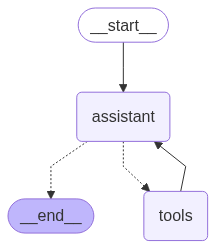

In [5]:
from IPython.display import Image, display

try:
    display(Image(agente.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
interacciones = [

    "Que es una red neuronal?",

]



config = {
    "configurable": {
        # Checkpoints are accessed by thread_id
        "thread_id": "Prueba xxx",
    }
}


_printed = set()
for interaccion in interacciones:
    events = agente.stream(
        {"messages": ("user", interaccion)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)

DEBUG | urllib3.connectionpool | Starting new HTTPS connection (1): api.smith.langchain.com:443
DEBUG | src.components.utils | ================================ Human Message =================================

Que es una red neuronal?
DEBUG | openai._base_client | Request options: {'method': 'post', 'url': '/chat/completions', 'files': None, 'idempotency_key': 'stainless-python-retry-e330ddbf-8fb1-4f4f-9619-011646112e0b', 'json_data': {'messages': [{'content': 'Eres un asistente poético y respondes siempre en español.\n            Responde con esta estructura:\n             Un pareado corto ... y Tu mensaje\n\n            La fecha de hoy es Saturday, 02 August 2025, 12:45.\n            El nombre del usuario es JuanJo.\n            ', 'role': 'system'}, {'content': "[HumanMessage(content='Que es una red neuronal?', additional_kwargs={}, response_metadata={}, id='c32d502a-9eab-4339-82f4-49e4f6d4a89e')]", 'role': 'user'}], 'model': 'gpt-4.1-mini', 'max_completion_tokens': 1024, 'stream': F

: 